# ENERGY 251 Term Project - Part A --- Mohammad Aljubran

In [1]:
# Load required software packages
import os
import sys
from scipy import stats
import time
import pandas as pd
from scipy.optimize import minimize, fsolve
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

In [2]:
# Function to format array printouts
def ndprint(aaa, name, format_string ='{0:.2f}'):
    print (name, [format_string.format(v) for i,v in enumerate(aaa)])

# # Heavy-End Characterization Routines (Credit Goes to ENERGY 251 Instructor and TA at Stanford University)

This partial code gives routines to construct the 2 Jacobeans described by Pedersen et al (SPE 77385) for expansion of the plus fraction of a crude oil. See the code snippets below for documentation of the variable names. 
Revision date: 12 November 2018

In [3]:
def jacobianAB(x, Np, nmax, wmp, zp):
    
    ii = np.arange(Np, nmax+1)
    sum1 = np.sum(np.exp(x[0] + x[1]*ii))
    sum2 = np.sum(np.exp(x[0] + x[1]*ii)*(14*ii-4))
    sum3 = np.sum(ii*np.exp(x[0] + x[1]*ii))
    sum4 = np.sum(ii*np.exp(x[0] + x[1]*ii)*(14*ii-4))
        
    # trial functions
    #f = np.array([wmp*sum1-sum2, zp-sum1])
    f = np.array([wmp*sum1-sum2, zp-sum1])
    # Jacobian
    J = np.array([[wmp*sum1-sum2, wmp*sum3-sum4], [-sum1, -sum3]])
    
    return J, f


def jacobianCD(x, Np, nmax, dp, dpm):

    ii = np.arange(Np, nmax+1)
    wmi = (14*ii)-4
    zi = np.exp(x[0] + x[1]*ii)
    densi = x[2] + x[3]*np.log(ii)
    sum1 = np.sum(zi*wmi)
    sum2 = np.sum(zi*wmi/densi)
    sum3 = np.sum(zi*wmi/densi**2)
    sum4 = np.sum(zi*wmi*np.log(ii)/densi**2)
    
    # trial functions
    f = np.array([dp*sum2-sum1, dpm - (x[2] + x[3]*np.log(Np-1))])

    # Jacobian
    J = np.array([[-dp*sum3, -dp*sum4], [-1, -np.log(Np-1)]])
    
    return J, f


In [4]:
def distrib(nmax, Np, zp, wmp, dp, dpm, tol = 1e-12, x0 = [-4, -0.05, 0.5, 0.1], maxIter = 100, 
            verbose = True, makePlots = True, writeData = True):
    '''
    Distribution al la Pedersen et al. (SPE 77385)
    
    REQUIRED INPUTS:
        nmax  :   max carbon number in distribution functions
        Np    :   carbon number of plus fraction
        zp    :   mole fraction of plus fraction
        wmp   :   molecular weight of plus fraction
        dp    :   density of plus fraction
        dpm   :   density of Nplus-1
        
    OPTIONAL INPUTS:
        tol   :   tolerance for the Newton iteration
        x0    :   initial guesses for [A, B, C, D]
        maxIter : maximum number of iterations for the Newton iteration
        verbose : output parameters and data at runtime
        makePlots:output plots at runtime
        writeData:write data to CSV files
    
    OUTPUTS:
        A, B, C, D : constants for the expansion procedure 
    
    '''
    tic = time.clock()
    tol = 1e-10
    
    # ln(zi) = A+B*i : solve for A and B
    iterNum = 0

    # initial estimate
    A = x0[0]
    B = x0[1]

    # Newton loop for A and B
    while iterNum < maxIter + 1:

        # Jacobian
        # Sample call to find latest update for A and B
        J, f = jacobianAB([A,B], Np, nmax, wmp, zp)
        chkf = np.sum(f**2)

        # solve linar eq: J*dv+f = 0 for dv
        dv = np.linalg.solve(J,f)

        # update A, B
        A -= dv[0]
        B -= dv[1]

        # check for convergence
        chkc = np.sum(dv**2)
        if chkc < tol or chkf < tol:
            ierr = 0
            break

        iterNum += 1

        if iterNum>100:
            raise Exception('Maximum number of iterations reached. Newton iteration not converged.')
    
    # sg = C + D*ln(Cn) : evaluate C and D

    iterNum = 0

    # initial estimate
    C = x0[2]
    D = x0[3]

    # Newton loop for C and D
    while iterNum < maxIter + 1:

        # Jacobian
        # Sample call to find the latest update for C and D
        # Note that A and B must be passed in
        J, f = jacobianCD([A,B,C,D], Np, nmax, dp, dpm)
        chkf = np.sum(f**2)

        # solve linar eq: J*dv+f = 0 for dv
        dv = np.linalg.solve(J, f)

        # update C,D
        C -= dv[0]
        D -= dv[1]

        # check for convergence
        chkc = np.sum(dv**2)
        if chkc < tol or chkf < tol:
            ierr=0
            break
        
        iterNum += 1
        if iterNum > 100:
            raise Exception('Maximum number of iterations reached. Newton iteration not converged.')
    
#     # Print fitted parameters
#     if verbose:
#         print('A = {:1.6}, B = {:1.6}, C = {:1.6}, D = {:1.6}'.format(A, B, C, D))

    cn = np.arange(Np, nmax+1)
    n = nmax + 1 - Np
    z = np.exp(A + B*cn)
    sg = C + D*np.log(cn)
    mw = 14*cn - 4
    
    # Other stuff that you might want to include goes here

   


        
    return A, B, C, D
          

This code uses the A,B,C,D values calculated using the distribution routine to calculate the mole fraction, molecular weight, and density of the n+ components 

In [5]:
def PlusFrac(Crange, A, B, C, D):

    MW_plus = [] # Molecular weight of n+ components [g/mole]
    z_plus = [] # Mole fraction of n+ components [fraction]
    den_plus = [] # Density of n+ components [g/cc at 15 deg C and 1 atm]
    
    for i in Crange:
        z_plus.append(np.exp(A + B*i)) # EQ 7.19 
        MW_plus.append(14*i-4) # EQ 7.20 
        den_plus.append(C + D*np.log(i)) # EQ 7.21 

    # Plot mole fraction and density
#     fig1, ax1 = plt.subplots()

#     ax2 = ax1.twinx()
#     l1 = ax1.plot(Crange, z_plus, 'b', label='Z')
#     l2 = ax2.plot(Crange, den_plus, 'r', label='Density')

#     ax1.set_xlabel('Carbon Number (SCN)')
#     ax1.set_ylabel('Mole Fraction')
#     ax2.set_ylabel('Density (gm/cc)')

#     ax1.legend(loc='upper left')
#     ax2.legend(loc='upper right')

#     plt.show()
    
    return z_plus, MW_plus, den_plus


This routine calculates the critical temperature, critical pressure, and accentricity of the n+ components. This routine is to be used in association with the previous routine as they are directly related and using similar variables

In [6]:
# Critical temperature calculation for n+ components 
def TC(coeff, d, M): 
    return (coeff[0]*d + coeff[1]*np.log(M) + coeff[2] * M + coeff[3]/M) # Eq 7.14

# Critical pressure calculation for n+ components
def PC(coeff, d, M): 
    return np.exp(coeff[4] + coeff[5] * d**coeff[8] + coeff[6]/M + coeff[7]/M**2) # Eq 7.15

# mi parameter calculation (needed for accentricity estimation) for n+ components
def MI(coeff, d, M):
    return coeff[9] + coeff[10]*M + coeff[11] * d + coeff[12] * M**2 # Eq 7.16 

def TPW(Crange, den_plus, MW_plus):

    Tc_plus = [] # Critical temperature [K]
    Pc_plus = [] # Critical pressure [atm]
    mi = [] # accentricity parameter - no expressed physical meaning
    omega_plus = [] # Accentricity 
    
    # PR-EOS Coeff Input
    coeff = [326.725, 52.3447, 0.577248, 1774.98, 2.68058, -0.532274, 204.507, \
             -9454.34, 0.25, 0.189723, 0.00742901, 0.0328795, -7.36151e-6]


    for i in range(len(Crange)): 
        Tc_plus.append(TC(coeff, den_plus[i], MW_plus[i]))
        Pc_plus.append(PC(coeff, den_plus[i], MW_plus[i]))
        
        mi = MI(coeff, den_plus[i], MW_plus[i])
        # Accentricity Equation 
        def f(x): # x represents accentricity 
            return 0.37464 -mi + 1.5422 * x - 0.26992 * x**2
        
        omegai = fsolve(f, 0.5)
        omegai = np.min(omegai)
        omega_plus.append(omegai)
        
#     # Plot critical temperature and pressure
#     fig2, ax1 = plt.subplots()

#     ax2 = ax1.twinx()
#     ax1.plot(Crange, Pc_plus, 'b', label='Pc [atm]')
#     ax2.plot(Crange, Tc_plus, 'r', label='Tc [K]')

#     ax1.set_xlabel('Carbon Number (SCN)')
#     ax1.set_ylabel('Critical Pressure [atm]')
#     ax2.set_ylabel('Critical Temperature [K]')


#     ax1.legend(loc='upper left')
#     ax2.legend(loc='upper right')

#     plt.show()
    return Tc_plus, Pc_plus, omega_plus

# Pseudoize Composition To The First 20 Pseudocomponents

In [7]:
# Split to 20 Pseudocomponents and estimate the EOS input Data
def Pseudo20():

    # -----------------------------  Input of the experimental results  ----------------------------------------------
    Name = {'CO2', 'N2', 'C1', 'C2', 'C3', 'iC4', 'nC4', 'iC5', 'nC5', 'C6', 'C7', 'C8', 'C9', \
            'C10-13', 'C14-17', 'C18-22', 'C23-27', 'C28-34', 'C35-45', 'C46-200'} # Proposed 20 grouping
    z_in = np.array([0.0032, 0.0004, 0.1565, 0.0413, 0.0402, 0.0101, 0.0285, 0.0153, 0.0176, \
                     0.0287, 0.0666, 0.0812, 0.0721, 0.4383]) # input mole fraction data
    MW_in = np.array([44.01, 28.01, 16.04, 30.07, 44.1, 58.12, 58.12, 72.15, 72.15, \
                      84, 96, 107, 121, 292]) # input molecular weight data (g/mole)
    den_in = np.array([0.8172, 0.8086, 0.2997, 0.3562, 0.507, 0.5629, 0.584, 0.6244, 0.6311, \
                       0.685, 0.722, 0.745, 0.764, 0.8959]) # input density data [g/cc]
    # Defined component critical temp input [K]
    Tc_in = np.array([304.2, 126.2, 190.6, 305.4, 369.8, 408.1, 425.2, 460.4, 469.6, 507.4])
    # Defined component critical pressure input [atm]
    Pc_in = np.array([72.9, 33.6, 45.4, 48.2, 41.9, 36.0, 37.5, 33.4, 33.3, 29.3])
    # Defined Component accentric factor input
    omega_in = np.array([0.228, 0.04, 0.008, 0.098, 0.152, 0.176, 0.193, 0.227, 0.251, 0.296]) 
    Nps = 20 # Number of pseudocomponents
    
    # -----------------------------  Set parameters as per Input Data ------------------------------------------------
    nmax = 200 # max carbon number in distribution functions
    Np = 10 # carbon number of plus fraction
    zp = 0.4383 # mole fraction of plus fraction
    wmp = 292 # molecular weight of plus fraction [g/mole]
    dp = 0.8959 # density of plus fraction [g/cc]
    dpm = 0.764 # density of Nplus-1 [g/cc]
    
    # Use the distribution function to calculates constants A, B, C, and D
    A,B,C,D = distrib(nmax, Np, zp, wmp, dp, dpm) # Check Example 2 in Notebook
    
    Crange = range(Np, nmax+1) # Range of heavy n+ components 
    # PR-EOS Coeff Input
    coeff = [326.725, 52.3447, 0.577248, 1774.98, 2.68058, -0.532274, 204.507, \
             -9454.34, 0.25, 0.189723, 0.00742901, 0.0328795, -7.36151e-6]
    

    # Calculate the mole fraction, molecular weight, and density properties of the n+ components (Example 2 in Notes)
    z_plus,MW_plus,den_plus = PlusFrac(Crange, A, B, C, D)
    # Calculate Tc, Pc, and w properties of the n+ components (Example 2 in notes)
    Tc_plus,Pc_plus,omega_plus = TPW(Crange, den_plus, MW_plus)

    # empty arrays to be filled for the calculated pseudo composition
    zi = [] 
    MW = []
    den = []
    wt = []
    Tc = []
    Pc = []
    omega = []

    # Assign values to new variables for the defined components 
    for i in range(13):
        zi.append(z_in[i])
        MW.append(MW_in[i])
        den.append(den_in[i])

    for i in range(10):
        Tc.append(Tc_in[i])
        Pc.append(Pc_in[i])
        omega.append(omega_in[i])

    # Calculate properties of the C7-C9 components in order using the given input

    for i in range(10, 13): 
        Tc.append(TC(coeff, den_in[i], MW_in[i])) 
        Pc.append(PC(coeff, den_in[i], MW_in[i]))

        mi = MI(coeff, den_in[i], MW_in[i])
        def f(x): # x represents accentricity 
            return 0.37464 -mi + 1.5422 * x - 0.26992 * x**2

        omegai = fsolve(f, 0.5)
        omegai = np.min(omegai)
        omega.append(omegai)

    # Creat a zip for the group carbon numbers

    azip = [0, 4, 8, 13, 18, 25, 36] # Represent lower ends in the plus arrays 
    bzip = [4, 8, 13, 18, 25, 36, 191] # Represent upper ends in the plus arrays 

    # Calculate mass fraction weighing average values to new pseudocomponents of the grouped components 
    for x, y in zip(azip, bzip):

        zi.append(np.sum(z_plus[j] for j in range(x, y)))
        MW.append(np.sum(z_plus[j] * MW_plus[j] for j in range(x, y))/np.sum(z_plus[j] for j in range(x, y)))
        den.append(np.sum(z_plus[j] * MW_plus[j] for j in range(x, y))/np.sum(z_plus[j] * MW_plus[j]/den_plus[j] for j in range(x, y)))
        Tc.append(np.sum(z_plus[j] * MW_plus[j] *Tc_plus[j] for j in range(x, y))/np.sum(z_plus[j]* MW_plus[j] for j in range(x, y)))
        Pc.append(np.sum(z_plus[j] * MW_plus[j] *Pc_plus[j] for j in range(x, y))/np.sum(z_plus[j]* MW_plus[j] for j in range(x, y)))
        omega.append(np.sum(z_plus[j] * MW_plus[j] *omega_plus[j] for j in range(x, y))/np.sum(z_plus[j]* MW_plus[j] for j in range(x, y)))

    # Calculate wt% to confirm the proposed grouping gives nearly equal weight percentages
    wt_tot = np.sum(zi[j] * MW[j] for j in range(Nps))
    
    for i in range(Nps):
        wt.append(zi[i] * MW[i]/wt_tot)
    
#     ndprint(wt, 'wt = ', format_string ='{0:.3f}')

    # Plot mole fraction and density 
#     fig1, ax1 = plt.subplots()

#     ax2 = ax1.twinx()
#     ax1.plot(range(1, Nps+1), zi, 'b', label='Z')
#     ax2.plot(range(1, Nps+1), den, 'r', label='Density')

#     ax1.set_xlabel('Carbon Number (SCN)')
#     ax1.set_ylabel('Mole Fraction')
#     ax2.set_ylabel('Density (gm/cc)')

#     ax1.legend(loc='upper left')
#     ax2.legend(loc='upper right')

#     plt.xticks(np.arange(1, Nps+1, step=1))
#     plt.show()

#     # Plot critical pressure and temperature 
#     fig2, ax1 = plt.subplots()

#     ax2 = ax1.twinx()
#     ax1.plot(range(1, Nps+1), Tc, 'b', label='Tc')
#     ax2.plot(range(1, Nps+1), Pc, 'r', label='Pc')

#     ax1.set_xlabel('Carbon Number (SCN)')
#     ax1.set_ylabel('Critical Temperature [K]')
#     ax2.set_ylabel('Critical Pressure [atm]')

#     ax1.legend(loc='upper right')
#     ax2.legend(loc='upper left')

#     plt.xticks(np.arange(1, Nps+1, step=1))
#     plt.show()

#     # Plot accentricity factor and wt
#     fig3, ax1 = plt.subplots()

#     ax2 = ax1.twinx()
#     ax1.plot(range(1, Nps+1), omega, 'b', label='Accentricity Factor')
#     ax2.plot(range(1, Nps+1), wt, 'r', label='wt')

#     ax1.set_xlabel('Carbon Number (SCN)')
#     ax1.set_ylabel('Accentricity Factor')
#     ax2.set_ylabel('wt')

#     ax1.legend(loc='upper right')
#     ax2.legend(loc='upper left')

#     plt.xticks(np.arange(1, Nps+1, step=1))
#     plt.show()
    
    Pc = [t * 101325 for t in Pc]
    return Name, np.array(zi), np.array(MW), np.array(den), np.array(Tc), np.array(Pc), np.array(omega)

Pseudo20()

({'C1',
  'C10-13',
  'C14-17',
  'C18-22',
  'C2',
  'C23-27',
  'C28-34',
  'C3',
  'C35-45',
  'C46-200',
  'C6',
  'C7',
  'C8',
  'C9',
  'CO2',
  'N2',
  'iC4',
  'iC5',
  'nC4',
  'nC5'},
 array([0.0032    , 0.0004    , 0.1565    , 0.0413    , 0.0402    ,
        0.0101    , 0.0285    , 0.0153    , 0.0176    , 0.0287    ,
        0.0666    , 0.0812    , 0.0721    , 0.12750477, 0.09041267,
        0.07698036, 0.05009087, 0.04218268, 0.03126327, 0.01986538]),
 array([ 44.01      ,  28.01      ,  16.04      ,  30.07      ,
         44.1       ,  58.12      ,  58.12      ,  72.15      ,
         72.15      ,  84.        ,  96.        , 107.        ,
        121.        , 155.49914789, 211.49914789, 273.60128311,
        343.60128311, 425.21659966, 544.14501307, 795.99664078]),
 array([0.8172    , 0.8086    , 0.2997    , 0.3562    , 0.507     ,
        0.5629    , 0.584     , 0.6244    , 0.6311    , 0.685     ,
        0.722     , 0.745     , 0.764     , 0.79745867, 0.83935659,
     

# Pseudoize Composition To The First 10 Pseudocomponents

In [8]:
# Split to 10 Pseudocomponents and estimate the EOS input Data
def Pseudo10():

    # -----------------------------  Input of the experimental results  ----------------------------------------------
    Name = {'CO2', 'N2-C1', 'C2', 'C3', 'iC4-nC4', 'iC5-nC5', 'C6', 'C7-9','C10-23', 'C24-200'} # Proposed 10 grouping
    z_in = np.array([0.0032, 0.0004, 0.1565, 0.0413, 0.0402, 0.0101, 0.0285, 0.0153, 0.0176, \
                     0.0287, 0.0666, 0.0812, 0.0721, 0.4383]) # input mole fraction data
    MW_in = np.array([44.01, 28.01, 16.04, 30.07, 44.1, 58.12, 58.12, 72.15, 72.15, \
                      84, 96, 107, 121, 292]) # input molecular weight data (g/mole)
#     MF_in = np.multiply(z_in, MW_in)
#     MW_in[13] = 0.9*MW_in[13]
#     z_in[13] = MF_in[13]/MW_in[13]
#     MW_in[12] = 0.9*MW_in[12]
#     z_in[12] = MF_in[12]/MW_in[12]
#     z_in = z_in/np.sum(z_in)
    den_in = np.array([0.8172, 0.8086, 0.2997, 0.3562, 0.507, 0.5629, 0.584, 0.6244, 0.6311, \
                       0.685, 0.722, 0.745, 0.764, 0.8959]) # input density data [g/cc]
    # Defined component critical temp input [K]
    Tc_in = np.array([304.2, 126.2, 190.6, 305.4, 369.8, 408.1, 425.2, 460.4, 469.6, 507.4])
    # Defined component critical pressure input [atm]
    Pc_in = np.array([72.9, 33.6, 45.4, 48.2, 41.9, 36.0, 37.5, 33.4, 33.3, 29.3])
    # Defined Component accentric factor input
    omega_in = np.array([0.228, 0.04, 0.008, 0.098, 0.152, 0.176, 0.193, 0.227, 0.251, 0.296]) 
    Nps = 10 # Number of pseudocomponents
    
    # -----------------------------  Set parameters as per Input Data ------------------------------------------------
    nmax = 200 # max carbon number in distribution functions
    Np = 10 # carbon number of plus fraction
    zp = 0.4383 # mole fraction of plus fraction
    wmp = 292 # molecular weight of plus fraction [g/mole]
    dp = 0.8959 # density of plus fraction [g/cc]
    dpm = 0.764 # density of Nplus-1 [g/cc]
    
    # Use the distribution function to calculates constants A, B, C, and D
    A,B,C,D = distrib(nmax, Np, zp, wmp, dp, dpm) # Check Example 2 in Notebook
    
    Crange = range(Np, nmax+1) # Range of heavy n+ components 
    # PR-EOS Coeff Input
    coeff = [326.725, 52.3447, 0.577248, 1774.98, 2.68058, -0.532274, 204.507, \
             -9454.34, 0.25, 0.189723, 0.00742901, 0.0328795, -7.36151e-6]
    
    # Calculate the mole fraction, molecular weight, and density properties of the n+ components (Example 2 in Notes)
    z_plus,MW_plus,den_plus = PlusFrac(Crange, A, B, C, D)
    # Calculate Tc, Pc, and w properties of the n+ components (Example 2 in notes)
    Tc_plus,Pc_plus,omega_plus = TPW(Crange, den_plus, MW_plus)

    # empty arrays to be filled for the calculated pseudo composition
    dummy = 7 # Number used to create a list of the size of the defined pseudocomponents 
    zi = [0] * dummy
    MW = [0] * dummy
    den = [0] * dummy
    wt = []
    Tc = [0] * dummy
    Pc = [0] * dummy
    omega = [0] * dummy
    omega_temp = [0] * dummy
    
    # Assign values to the defined components 
    
    kzip = [0, 2, 3, 6] # Represent element index
    azip = [0, 3, 4, 9] # Represent lower ends
    
    for x,y in zip(kzip, azip):
        zi[x] = z_in[y]
        MW[x] = MW_in[y]
        den[x] = den_in[y]
        Tc[x] = Tc_in[y]
        Pc[x] = Pc_in[y]
        omega[x] = omega_in[y]
    
    # Assign values to pseudocomponents that are formed using defined components 
    kzip = [1,4,5] # Represent element index
    azip = [1,5,7] # Represent lower ends
    bzip = [2,6,8] # Represent upper ends

    for m, x, y in zip(kzip, azip, bzip):
        zi[m] = np.sum(z_in[j] for j in [x,y])
        MW[m] = np.sum(np.multiply(z_in[j], MW_in[j]) for j in [x,y])/np.sum(z_in[j] for j in [x,y])
        den[m] = np.sum(np.multiply(z_in[j], den_in[j]) for j in [x,y])/np.sum(z_in[j] for j in [x,y])
        Tc[m] = np.sum(np.multiply(z_in[j], Tc_in[j]) for j in [x,y])/np.sum(z_in[j] for j in [x,y])
        Pc[m] = np.sum(np.multiply(z_in[j], Pc_in[j]) for j in [x,y])/np.sum(z_in[j] for j in [x,y])
        omega[m] = np.sum(np.multiply(z_in[j], omega_in[j]) for j in [x,y])/np.sum(z_in[j] for j in [x,y])

    # Calculate properties of the C7-C9 components in order using the given input
    
    zi.append(np.sum(z_in[j] for j in range(10,13)))
    MW.append(np.sum(np.multiply(z_in[j], MW_in[j]) for j in range(10,13))/np.sum(z_in[j] for j in range(10,13)))
    den.append(np.sum(z_in[j] * MW_in[j] for j in range(10,13))/np.sum(z_in[j] * MW_in[j]/den_in[j] for j in range(10,13)))
    Tc.append(np.sum(z_in[j] * MW_in[j] * TC(coeff, den_in[j], MW_in[j]) for j in range(10,13))/ \
                     np.sum(z_in[j] * MW_in[j] for j in range(10,13)))
    Pc.append(np.sum(z_in[j] * MW_in[j] * PC(coeff, den_in[j], MW_in[j]) for j in range(10,13))/ \
                     np.sum(z_in[j] * MW_in[j] for j in range(10,13)))
 
    for i in range(10,13):

        mi = MI(coeff, den_in[i], MW_in[i])
        def f(x): # x represents accentricity 
            return 0.37464 -mi + 1.5422 * x - 0.26992 * x**2

        omegai = fsolve(f, 0.5)
        omega_temp[i-10] = np.min(omegai)

    omega.append(np.sum(z_in[j] * MW_in[j] * omega_temp[j-10] for j in range(10,13))/ \
                 np.sum(z_in[j] * MW_in[j] for j in range(10,13)))

    # Creat a zip for the group carbon numbers

    azip = [0, 14] # Represent lower ends in the plus arrays 
    bzip = [14, 191] # Represent upper ends in the plus arrays 

    # Calculate mass fraction weighing average values to new pseudocomponents of the grouped components 
    for x, y in zip(azip, bzip):

        zi.append(np.sum(z_plus[j] for j in range(x, y)))
        MW.append(np.sum(z_plus[j] * MW_plus[j] for j in range(x, y))/np.sum(z_plus[j] for j in range(x, y)))
        den.append(np.sum(z_plus[j] * MW_plus[j] for j in range(x, y))/np.sum(z_plus[j] * MW_plus[j]/den_plus[j] for j in range(x, y)))
        Tc.append(np.sum(z_plus[j] * MW_plus[j] *Tc_plus[j] for j in range(x, y))/np.sum(z_plus[j]* MW_plus[j] for j in range(x, y)))
        Pc.append(np.sum(z_plus[j] * MW_plus[j] *Pc_plus[j] for j in range(x, y))/np.sum(z_plus[j]* MW_plus[j] for j in range(x, y)))
        omega.append(np.sum(z_plus[j] * MW_plus[j] *omega_plus[j] for j in range(x, y))/np.sum(z_plus[j]* MW_plus[j] for j in range(x, y)))

    # Calculate wt% to confirm the proposed grouping gives nearly equal weight percentages
    wt_tot = np.sum(zi[j] * MW[j] for j in range(Nps))
    
    for i in range(Nps):
        wt.append(zi[i] * MW[i]/wt_tot)
#     print(zi)
#     ndprint(wt, 'wt = ', format_string ='{0:.3f}')

#     # Plot mole fraction and density 
#     fig1, ax1 = plt.subplots()

#     ax2 = ax1.twinx()
#     ax1.plot(range(1, Nps+1), zi, 'b', label='Z')
#     ax2.plot(range(1, Nps+1), den, 'r', label='Density')

#     ax1.set_xlabel('Carbon Number (SCN)')
#     ax1.set_ylabel('Mole Fraction')
#     ax2.set_ylabel('Density (gm/cc)')

#     ax1.legend(loc='upper left')
#     ax2.legend(loc='upper right')

#     plt.xticks(np.arange(1, Nps+1, step=1))
#     plt.show()

#     # Plot critical pressure and temperature 
#     fig2, ax1 = plt.subplots()

#     ax2 = ax1.twinx()
#     ax1.plot(range(1, Nps+1), Tc, 'b', label='Tc')
#     ax2.plot(range(1, Nps+1), Pc, 'r', label='Pc')

#     ax1.set_xlabel('Carbon Number (SCN)')
#     ax1.set_ylabel('Critical Temperature [K]')
#     ax2.set_ylabel('Critical Pressure [atm]')

#     ax1.legend(loc='upper right')
#     ax2.legend(loc='upper left')

#     plt.xticks(np.arange(1, Nps+1, step=1))
#     plt.show()

#     # Plot accentricity factor and wt
#     fig3, ax1 = plt.subplots()

#     ax2 = ax1.twinx()
#     ax1.plot(range(1, Nps+1), omega, 'b', label='Accentricity Factor')
#     ax2.plot(range(1, Nps+1), wt, 'r', label='wt')

#     ax1.set_xlabel('Carbon Number (SCN)')
#     ax1.set_ylabel('Accentricity Factor')
#     ax2.set_ylabel('wt')

#     ax1.legend(loc='upper right')
#     ax2.legend(loc='upper left')

#     plt.xticks(np.arange(1, Nps+1, step=1))
#     plt.show()

#     plt.plot(range(1, Nps+1), MW, 'b', label='MW')
#     plt.show()
#     MW[-1] = 486
#     MW[-2] = 200
#     MW[-3] = 100
    
    Pc = [t * 101325 for t in Pc]
    return Name, np.array(zi), np.array(MW), np.array(den), np.array(Tc), np.array(Pc), np.array(omega)

Pseudo10()

({'C10-23',
  'C2',
  'C24-200',
  'C3',
  'C6',
  'C7-9',
  'CO2',
  'N2-C1',
  'iC4-nC4',
  'iC5-nC5'},
 array([0.0032    , 0.1569    , 0.0413    , 0.0402    , 0.0386    ,
        0.0329    , 0.0287    , 0.2199    , 0.30670739, 0.13159261]),
 array([ 44.01      ,  16.07051625,  30.07      ,  44.1       ,
         58.12      ,  72.15      ,  84.        , 108.25875398,
        207.90650014, 487.99958537]),
 array([0.8172    , 0.30099739, 0.3562    , 0.507     , 0.57847902,
        0.62798419, 0.685     , 0.74541602, 0.83996133, 0.95934056]),
 array([304.2       , 190.43581899, 305.4       , 369.8       ,
        420.72564767, 465.32158055, 507.4       , 568.51581882,
        692.85240447, 957.37638002]),
 array([7386592.5       , 4597106.85468451, 4883865.        ,
        4245517.5       , 3759918.75      , 3378834.57446808,
        2968822.5       , 2644379.85242728, 1899003.82124614,
        1278525.51654904]),
 array([0.228     , 0.00808158, 0.098     , 0.152     , 0.18855181,
    

# Rachford-Rice Equation and Derivative Definition

In [9]:
def RR(L, Nc, z, K):

    F = np.sum(np.divide(np.multiply(z, (1-K)),(K+(1-K)*L)))
    
    return F

def DRR(L, Nc, z, K):

    dF = np.sum(np.divide(-np.multiply(z, (1-K)**2),(K+(1-K)*L)**2))
    
    return dF

# Mixed Newton-Raphson and Bisection Method To Solve Rachford-Rice
 

In [10]:
def RachfordNewtonBisection(l, Nc, z, K):

    # Input is formatted as follows: 
    # "l_o" - scalar is the first liquid fraction guess
    # "Nc" - scalar is the number of components in the mixtures
    # "z" is a list with all zi values of each component i with length Nc
    # "K" is a list of length Nc with all ki values of each component i
    # 'L' is a variable introduced to construct the Rachford-Rice function F(L)
    # 'tol' is the convergence tolerance criteria 
    
    F = 0
    iterate = 0
    error = 1
    error_vec = []
    tol = 1e-5
    l_max_vec = []
    l_min_vec = []
    l_vec = []
    iterate_vec = []
    
    if RR(0, Nc, z, K) >= 0 and RR(1, Nc, z, K) <= 0:
        
        l_min = 0
        l_max = 1
        l_dummy_min = np.min(np.divide((z-K),(1-K)))
        l_dummy_max = np.max(np.divide((np.multiply(z,K)-K),(1-K)))
        l_min = max(l_min, l_dummy_min)
        l_max = min(l_max, l_dummy_max)

    elif RR(0, Nc, z, K) >= 0 and RR(1, Nc, z, K) >= 0:
        l_min = 1
#         l_max = np.divide(-np.min(K),(1-np.min(K)))
        l_max = np.max(np.divide(np.multiply(z,K) - K, 1 - K))

    elif RR(0, Nc, z, K) <= 0 and RR(1, Nc, z, K) <= 0:
#         l_min = np.divide(-np.max(K),(1-np.max(K)))
        l_min = np.min(np.divide(z - K , 1 - K))
        l_max = 0
    else:
        l_min = np.min(np.divide((z-K),(1-K)))
        l_max = np.max(np.divide((np.multiply(z,K)-K),(1-K)))
        
    l = 0.5*(l_max+l_min)
    
    # Converge to the the liquid fraction l with error 
    while error > tol:
        
        l_max_vec.append(l_max)
        l_min_vec.append(l_min)
        l_vec.append(l)
        
        if RR(l, Nc, z, K)>0:
            l_min = l
        elif RR(l, Nc, z, K)<0:
            l_max = l
        
        l_init = l
        l = l_init - RR(l_init, Nc, z, K)/DRR(l_init, Nc, z, K)
        
        if (l < l_max and l > l_min):
            l = l
        else:
            l = 0.5*(l_max+l_min)

        iterate += 1
        error = abs(l-l_init)
        error_vec.append(error)
        iterate_vec.append(iterate)
        
#     print('iterations = ', iterate)
#     ndprint(error_vec, 'error = ', format_string ='{:10.5e}')

#     # Plot the error as it converges to the tolerance threshhold 
#     plt.figure(0); plt.plot(iterate_vec, error_vec); plt.title('Error Plot'); plt.ylabel('Liquid Fraction Error')
#     plt.xlabel('Iteration'); plt.xticks(np.arange(1, iterate +1, 1.0)); plt.show()
    
#     # Plot the l, l_min and l_max minimum values as they converge 
#     plt.figure(1); plt.plot(iterate_vec, l_vec); plt.plot(iterate_vec, l_max_vec); plt.plot(iterate_vec, l_min_vec); 
#     plt.title('Liquid Fraction Convergence Plot');  plt.ylabel('Liquid Fraction'); plt.xlabel('Iteration'); 
#     plt.xticks(np.arange(1, iterate +1, 1)); plt.legend(['L', 'L_max', 'L_min'], loc='lower right'); plt.show()
    return l

# Calculating Mixture a's & b's, and EOS kij Interaction Coefficients 

In [11]:
def kij(EOS):
    
    x = np.zeros([100, 100])
    y = np.zeros([100, 100])
    z = np.zeros([100, 100])

    x[1, 7] = - 0.08
    x[1, 8] = - 0.18
    x[1, 9] = - 0.18
    
        
    if EOS is 'PR':
        return x
    elif EOS is 'SRK':
        return x
    elif EOS is 'RK':
        return x
    elif EOS is 'VDW':
        return x

In [12]:
def calc_a(EOS, T, Tc, Pc, omega):
    '''calculates ai for each component for the EOS of interest
       EOS: Equation of state (PR, SRK, or RK)
       T, Tc: temperature and critical temperature of the component
       Pc: critical pressure of the component
       omega: accentric factor for the component'''

    R = 8.314

    if EOS is 'PR':
        fw = 0.37464 + 1.54226*omega - 0.26992*omega**2
        a1 = np.divide(0.45724*R**2*Tc**2 , Pc)
        a2 = (1 + np.multiply(fw, (1 - np.sqrt(np.divide(T, Tc)))))**2
        a  = np.multiply(a1, a2)
    elif EOS is 'SRK':
        fw = 0.48 + 1.574*omega - 0.176*omega**2
        a1 = np.divide((0.42748*R**2*Tc**2), Pc)
        a2 = (1 + np.multiply(fw, (1 - np.sqrt(np.divide(T, Tc)))))**2
        a  = np.multiply(a1, a2)
    elif EOS is 'RK':
        a = np.divide(0.42748*R**2*Tc**(5/2), (Pc*T**0.5))
    elif EOS is 'VDW':
        a = 27*R**2 *Tc**2/(64*Pc)
    else:
        print('parameters for his EOS is not defined')

    return a


def calc_b(EOS, Tc, Pc):
    '''calculates ai for each component for the EOS of interest
    EOS: Equation of state (PR, SRK, or RK)
    Tc: critical temperature of the component
    Pc: critical pressure of the component
    '''

    R = 8.314 # gas constant

    # The below if statement computes b for each 
    # componenet based on the EOS of
    # interest (Table 5.1 in the course reader)
    if EOS is 'PR':
        b = np.divide(0.07780*R*Tc, Pc)
    elif EOS is 'SRK':
        b = np.divide(0.08664*R*Tc, Pc)
    elif EOS is 'RK':
        b = np.divide(0.08664*R*Tc ,Pc)
    elif EOS is 'VDW':
        b = R*Tc/(8*Pc)
    return b

In [13]:
def find_am(EOS, y, T, Tc, Pc, omega):
    ''' calculates the a parameter for the EOS of interest
        EOS: equation of state of interest (PR, SRK, RK)
        y: vapor or liquid compositions
        T, Tc: temperature value and critical temperature array
        Pc: critical pressure array
        omega: accentric factors array '''
    
    kijs = kij(EOS)
    am = np.sum(y[i]*y[j]*np.sqrt(calc_a(EOS, T, Tc[i], Pc[i], omega[i])\
               *calc_a(EOS, T, Tc[j], Pc[j], omega[j]))*(1-kijs[i,j]) \
               for i in range(len(y)) for j in range(len(y)))
    return am

def find_bm(EOS, y, Tc, Pc):
    '''This function computes the b for the mixture for the EOS of interest
        EOS: Equation of state (PR, SRK, or RK)
        y: liquid or vapor compositions array
        Tc and Pc: critical temperature and pressure array
    '''
    bm = np.sum(np.multiply(y, calc_b(EOS, Tc, Pc)))
    return bm

# Calculating Z-Factor Using a Cubic EOS of Interest

In [14]:
def Z_factor(EOS, P, T, a, b):
    '''This function computes the Z factor for the cubic EOS of interest
       EOS: equation of state (PR, SRK, or RK)
       P, T: pressure and temperature
       a, b: the vapor or liquid parameters of equation of state
    '''

    R = 8.314 # gas constant

    if EOS is 'PR':
        u = 2
        w = -1
    elif EOS is 'SRK':
        u = 1
        w = 0
    elif EOS is 'RK':
        u = 1
        w = 0
    elif EOS is 'VDW':
        u = 0
        w = 0
        
    A = np.divide(a*P, R**2*T**2)
    B = np.divide(b*P, R*T)

    Coeffs = list()
    Coeffs.append(1)
    Coeffs.append(-(1 + B - u*B))
    Coeffs.append(A + w*B**2 - u*B - u*B**2)
    Coeffs.append(-np.multiply(A, B) - w*B**2 - w*B**3)

    Z = np.roots(Coeffs)
    # remove the roots with imaginary parts
    Z = np.real(Z[np.imag(Z) == 0])
    return Z

# Choose Z Root With Minimum Gibb's Free Energy

In [15]:
def MinGibbZ (EOS, P, T, Tc, Pc, x, omega, a, b):
    #This function determines the Z root with the minimum Gibb's free energy for each phase
    R = 8.314 # gas constant
    vlike_term = []
    llike_term = []
    Z = 0
    Z_max = max(Z_factor(EOS,P,T,a,b))
    Z_min = min(Z_factor(EOS,P,T,a,b))
    
    fug_vlike = get_fug(EOS, x, Z_max, Tc, Pc, P, T, omega, a, b)
    fug_llike = get_fug(EOS, x, Z_min, Tc, Pc, P, T, omega, a, b)
    
    for i in range(len(x)):
    
        vlike_term.append(np.log(np.divide(fug_vlike[i], x[i]*P)))
        llike_term.append(np.log(np.divide(fug_llike[i], x[i]*P)))
    
    diff_term = np.array(llike_term) - np.array(vlike_term)
    dG = R*T*np.sum(np.multiply(x, diff_term))
    
    if dG >= 0:
        Z = Z_max
              
    elif dG < 0:
        Z = Z_min
    
    return Z

# Calculating Liquid and Vapor Fugacity of All Components

In [16]:
def get_fug(EOS, y, Z, Tc, Pc, P, T, omega, a, b):
    '''This function computes the liquid or vapor fugacity of all components
       using Eq. 6.8 in course reader
       parameters needed:
       EOS: equation of state (PR, SRK, or RK)
       y: liquid or vapor compositions
       Z: z-factors for vapor or liquid
       Tc and Pc: critical temperature and pressure for all individual comp.s
       P, T: pressure and temperature of the system
       omega: accentric factors for all individual components
       a and b: EOS parameters as computed in another function
    '''
    R = 8.314 # gas constant

    if EOS is 'PR':
        u = 2
        w = -1
        kijs = kij(EOS)
    elif EOS is 'SRK':
        u = 1
        w = 0
        kijs = kij(EOS)
    elif EOS is 'RK':
        u = 1
        w = 0
        kijs = kij(EOS)
    elif EOS is 'VDW':
        u = 0
        w = 0
        kijs = kij(EOS)
    
    # You should edit this function to give back a vector of fugacities for all
    # components that are passed to this function. 
    
    # Find A and B as per EOS
    A = np.divide(a*P, R**2*T**2)
    B = np.divide(b*P, R*T)
    
    # Find bi/b --'bib'-- and deli and also fugacity 
    bib = []
    delta = []
    lnphi = []
    fug = []
    for i in range(len(y)):
        
        bib.append(np.divide(Tc[i]/Pc[i], np.sum(y[j]*Tc[j]/Pc[j] for j in range(len(y)))))
        delta.append(np.multiply(2*np.sqrt(calc_a(EOS, T, Tc[i], Pc[i], omega[i]))/a, \
        np.sum(y[j]*np.sqrt(calc_a(EOS, T, Tc[j], Pc[j], omega[j]))*(1-kijs[i,j]) for j in range(len(y)))))

        lnphi.append(bib[i]*(Z-1) - np.log(Z-B) + np.divide(A, B*np.sqrt(u**2-4*w))\
        *(bib[i]-delta[i])*np.log(np.divide((2*Z+B*(u+np.sqrt(u**2-4*w))), (2*Z+B*(u-np.sqrt(u**2-4*w))))))
        
        fug.append(np.multiply(np.exp(lnphi[i]),y[i])*P)  
    return fug

# Flash Calculations Main Algorithm

In [17]:
def main(T, P, Nps):
    # The inputs of the problem:
    R = 8.314 # gas constant
    
    # Decide which pseudoization arrangement is desired
    if Nps == 20:
        Names,zi,MW,den,Tc,Pc,omega = Pseudo20()
    elif Nps == 10:
        Names,zi,MW,den,Tc,Pc,omega = Pseudo10()
    
    # Note the units: zi [fraction], MW[g/mole], den [g/cc], Tc[K], Pc[Pa], omega [unitless]

    Nc = zi.size # number of components
    Ki = np.multiply(Pc/P, np.exp(5.37*np.multiply((1+omega), (1-Tc/T)))) # inital K-values Using Wilson EQ
    Ki[np.isnan(Ki)] = 0.1
    EOS = 'PR' # Equation of State we are interested to use
    tol  = 1e-5
    conv = 0
    
    # using Rachford Rice equation to obtain l (Flash)
    # initial guess
    l_initial = 0.5
    criteria = np.ones(Nc) # random assignment to enter the loop
    record = []
    iterate = 0
    
    # Construct Rachford-Rice function F(L) to plot 
    L = sp.Symbol('L')
    F = np.sum(np.divide(np.multiply(zi, (1-Ki)),(Ki+(1-Ki)*L)))
    
    while all(x > tol for x in criteria):
        
        # Plot Rachford-Rice: 
        #sp.plot(F, xlim=[-1, 5], ylim=[-2,2])
        
        l = RachfordNewtonBisection(l_initial, Nc, zi, Ki)
        #print('Rachford-Rice L = ', l)
        
        # calculating liquid and gas compositions (Eq. 6.15 and 6.16, respectively)
        xi = np.divide(zi, l+(1-l)*Ki)
        yi = np.divide(np.multiply(Ki, zi), (l+(1-l)*Ki))
        
        # calculating the a's and b's of the vapor and liquid phases
        av = find_am(EOS,yi,T,Tc,Pc,omega)
        al = find_am(EOS,xi,T,Tc,Pc,omega)

        bv = find_bm(EOS,yi,Tc,Pc)
        bl = find_bm(EOS,xi,Tc,Pc)

        # calculating the vapor and liquid Z-factors
        
        #Method 1: Max/Min Approach:
#         Zv = max(Z_factor(EOS,P,T,av,bv))
#         Zl = min(Z_factor(EOS,P,T,al,bl))
        
        #Method 2: Min Free Gibb's Energy Approach:
        Zv = MinGibbZ(EOS, P, T, Tc, Pc, yi, omega, av, bv)
        Zl = MinGibbZ(EOS, P, T, Tc, Pc, xi, omega, al, bl)
        
        # calculating the vapor and liquid volumes from PV = ZRT
        Vv = np.divide(Zv*R*T, P)
        Vl = np.divide(Zl*R*T, P)

        # Fugacity values of vapor and liquid
        fug_v = get_fug(EOS, yi, Zv, Tc, Pc, P, T, omega, av, bv)
        fug_l = get_fug(EOS, xi, Zl, Tc, Pc, P, T, omega, al, bl)
        
        # Calculate for convergence 
        criteria = np.absolute(np.divide(fug_l,fug_v) -1)
        
        # Update Ki values and let the loop check if fugacities are equal
        Ki = np.multiply(np.divide(fug_l,fug_v), Ki)
        Ki[np.isnan(Ki)] = 0.1
        iterate += 1
    
    return l, xi, yi, Vv, Vl, Ki
#     v = 1-l
#     V = l*Vl+ v*Vv
    
#     if l>1:
#         l = 1; v = 0
#         V = l*Vl+ v*Vv
#         xi = zi
#         yi = np.zeros(len(zi))
    

#     elif l<0:
#         l = 0; v = 1
#         V = l*Vl+ v*Vv
#         xi = np.zeros(len(zi))
#         yi = zi
    
#     print('V = ', V)
#     ndprint(xi, 'xi = ', format_string ='{0:.3f}')
#     ndprint(yi, 'yi = ', format_string ='{0:.3f}')
#     print('Vl = {:.5e}'.format(Vl))
#     print('Vv = {:.5e}'.format(Vv))
#     print('l = {:.3f}'.format(l))
#     print('v = {:.3f}'.format(v))
#     print('Iterateions = ', iterate)

# Constant Mass Expansion (Bubble Point Pressure) Algorithm - Newton Raphson Convergence Algorithm

In [18]:
def BPmain(T, Pi, Nps):
    
    # Decide which pseudoization arrangement is desired
    if Nps == 20:
        Names,zi,MW,den,Tc,Pc,omega = Pseudo20()
    elif Nps == 10:
        Names,zi,MW,den,Tc,Pc,omega = Pseudo10()
        
    # The inputs of the problem:
    P = Pi # initial pressure Pa
    R = 8.314 # gas constant
    
    # Convergence tolerance for the bubble point pressure calculations
    tol = 1e-5
    l_tol = 5e-3
    k = 1
    
    l,xi,yi,Vv,Vl,Ki = main(T, P, Nps)
    err = np.sum(np.multiply(zi, Ki)) - 1
    
    # Create variables and vectors to initiate and store values
    err_vec = [err]
    P_vec = [P]
    l_vec = [l]
    
    P +=1e4
    P_vec.append(P)
    dP = 1e4
    l,xi,yi,Vv,Vl,Ki = main(T, P, Nps)
    err = np.sum(np.multiply(zi, Ki)) - 1
    err_vec.append(err)
    l_vec.append(l)
    
    while np.absolute(l-1)>l_tol:

        P = P - err_vec[k]/((err_vec[k] - err_vec[k-1])/dP)
        P_vec.append(P)
        k += 1
        dP = P_vec[k] - P_vec[k-1]
        
        l,xi,yi,Vv,Vl,Ki = main(T, P, Nps)
        err = np.sum(np.multiply(zi, Ki)) - 1
        err_vec.append(err)
        l_vec.append(l)
        if l_vec[k]>1:
            T = (P_vec[k]+P_vec[k-1])/2
            l = 1
        print('iteration', k)
        print('Pressure = ', P, 'l = ', l, 'error = ', err)
 
    return P

In [19]:
# Find Bubble Points of the different pseudiaztions (10 and 20)
# NOTE: In order to capture accurate bubble point pressure values:
# Go to BPmain and make sure the 'l_tol' variable = 1e-3 or 1e-4 and that the 'precision controller' variable = 1e3. 
#P_bub20 = BPmain(99+ 273.15, 1e7, 20)
P_bub10 = BPmain(400+ 273.15, 1e6, 20)
#print('20 PS BP = ', P_bub20, '10 PS BP', P_bub10)
# Results show Bubble Point Pressure with 20 PS = 5.974e6 Pa and Bubble Point Pressure with 10 PS = 6.132e6 Pa
# Note that experimental data show Bubble Point Pressure of 4.210e6 Pa

iteration 2
Pressure =  1818845.165423002 l =  0.2112851896316309 error =  3.5146951597639307
iteration 3
Pressure =  2511923.1685044467 l =  0.2661030215101638 error =  2.170493007324879
iteration 4
Pressure =  3631041.2687763292 l =  0.35389685610505484 error =  1.1429836950321963
iteration 5
Pressure =  4875929.0047054915 l =  0.4548126415301124 error =  0.5994007943273487
iteration 6
Pressure =  6248648.228942966 l =  0.5797705600740535 error =  0.2826550253836395
iteration 7
Pressure =  7473624.2987587815 l =  0.7201449056810885 error =  0.11769630255136265
iteration 8
Pressure =  8347631.757447781 l =  0.8585742070807341 error =  0.03983840128867744
iteration 9
Pressure =  8794844.68386707 l =  0.955367692411707 error =  0.009795444243600793
iteration 10
Pressure =  8940657.53708205 l =  0.9751414895374331 error =  0.004405779977469715
iteration 11
Pressure =  9059852.224808572 l =  1 error =  -3.046058143496566e-07


Text(0.5,1,'Experimental and PS20 & PS10 Saturation Pressure (No Tuning)')

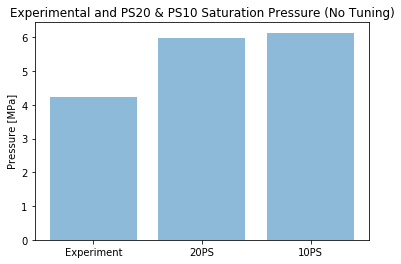

In [20]:
x = ['Experiment', '20PS', '10PS']
y = [4.22,5.975350,6.133561]

plt.bar(x, y, align='center', alpha=0.5)
plt.ylabel('Pressure [MPa]')
plt.title('Experimental and PS20 & PS10 Saturation Pressure (No Tuning)')

# Dew Point Pressure Algorithm - Newton Raphson Convergence Algorithm

In [21]:
def DPmainT(Ti, P, Nps):
    
    # Decide which pseudoization arrangement is desired
    if Nps == 20:
        Names,zi,MW,den,Tc,Pc,omega = Pseudo20()
    elif Nps == 10:
        Names,zi,MW,den,Tc,Pc,omega = Pseudo10()
        
    # The inputs of the problem:
    T = Ti # initial pressure Pa
    R = 8.314 # gas constant
    
    # Convergence tolerance for the bubble point pressure calculations
    tol = 1e-5
    l_tol = 5e-2
    k =1
    
    l,xi,yi,Vv,Vl,Ki = main(T, P, Nps)
    err = np.sum(np.divide(zi, Ki)) - 1
    
    # Create variables and vectors to initiate and store values
    err_vec = [err]
    T_vec = [T]
    l_vec = [l]
    
    T += 10
    T_vec.append(T)
    dT = 10
    l,xi,yi,Vv,Vl,Ki = main(T, P, Nps)
    err = np.sum(np.divide(zi, Ki)) - 1
    err_vec.append(err)
    l_vec.append(l)
    
    while np.absolute(l)>l_tol:

        T = T - err_vec[k]/((err_vec[k] - err_vec[k-1])/dT)
        T_vec.append(T)
        k += 1
        dT = T_vec[k] - T_vec[k-1]
        
        l,xi,yi,Vv,Vl,Ki = main(T, P, Nps)
        err = np.sum(np.divide(zi, Ki)) - 1
        err_vec.append(err)
        l_vec.append(l)
        
        if l_vec[k]<0:
            T = (T_vec[k]+T_vec[k-1])/2
            l = 0
        print('iteration', k)
        print('Temp = ', T, 'l = ', l, 'error = ', err)
 
    return T

In [22]:
# Find Bubble Points of the different pseudiaztions (10 and 20)
# NOTE: In order to capture accurate bubble point pressure values:
# Go to BPmain and make sure the 'l_tol' variable = 1e-3 or 1e-4 and that the 'precision controller' variable = 1e3. 
#P_bub20 = BPmain(99+ 273.15, 1e7, 20)
D_bub10 = DPmainT(600, 6.5e6, 10)
#print('20 PS BP = ', P_bub20, '10 PS BP', P_bub10)
# Results show Bubble Point Pressure with 20 PS = 5.974e6 Pa and Bubble Point Pressure with 10 PS = 6.132e6 Pa
# Note that experimental data show Bubble Point Pressure of 4.210e6 Pa

iteration 2
Temp =  632.4662785181893 l =  0.7909823049252415 error =  6.520045842682858
iteration 3
Temp =  651.9774965027157 l =  0.7381721192808995 error =  3.5562648005211077
iteration 4
Temp =  675.389164485805 l =  0.6614426702026598 error =  1.857899589766932
iteration 5
Temp =  700.9999860370934 l =  0.5656086577590087 error =  0.9651061127327087
iteration 6
Temp =  728.6851798328222 l =  0.454238110388263 error =  0.4783665638093817
iteration 7
Temp =  755.8941277265258 l =  0.3325973868003159 error =  0.20549995337488003
iteration 8
Temp =  776.3855961206691 l =  0.2124379251122706 error =  0.07366310835748813
iteration 9
Temp =  787.835090808764 l =  0.1115521507646348 error =  0.021435962439789513
iteration 10
Temp =  792.5343891099833 l =  0.04035591978413251 error =  0.0023909950070284403


# Volume Shift Routine

In [23]:
def VolumeShift(Nps, b):
        
    # -----------------------------  Input of the experimental results  ----------------------------------------------
    z_in = np.array([0.0032, 0.0004, 0.1565, 0.0413, 0.0402, 0.0101, 0.0285, 0.0153, 0.0176, \
                     0.0287, 0.0666, 0.0812, 0.0721, 0.4383]) # input mole fraction data
    MW_in = np.array([44.01, 28.01, 16.04, 30.07, 44.1, 58.12, 58.12, 72.15, 72.15, \
                      84, 96, 107, 121, 292]) # input molecular weight data (g/mole)
    den_in = np.array([0.8172, 0.8086, 0.2997, 0.3562, 0.507, 0.5629, 0.584, 0.6244, 0.6311, \
                       0.685, 0.722, 0.745, 0.764, 0.8959]) # input density data [g/cc]
    # Defined component critical temp input [K]
    Tc_in = np.array([304.2, 126.2, 190.6, 305.4, 369.8, 408.1, 425.2, 460.4, 469.6, 507.4])
    # Defined component critical pressure input [atm]
    Pc_in = np.array([72.9, 33.6, 45.4, 48.2, 41.9, 36.0, 37.5, 33.4, 33.3, 29.3])
    # Defined Component accentric factor input
    omega_in = np.array([0.228, 0.04, 0.008, 0.098, 0.152, 0.176, 0.193, 0.227, 0.251, 0.296])

    T = 99 + 273.15 # in Kelvin
    R = 8.314 # gas constant
    EOS = 'PR'
    ci = [3.7] #Start with ci of CO2 = 3.7 cc/mole
     # Decide which pseudoization arrangement is desired
    if Nps == 20:
        Names,zi,MW,den,Tc,Pc,omega = Pseudo20()
        first_heavy = 10 # order of first heavy component in pseudo20
        Si = [0, -0.1540, -0.1540, -0.1002, -0.08501, -0.07935, -0.06413,\
              -0.04350, -0.04183, -0.01478] 
    elif Nps == 10:
        Names,zi,MW,den,Tc,Pc,omega = Pseudo10()
        first_heavy = 7 # order of first heavy component in pseudo10
        # tabulated volume correction of light components [cc/mol]
        Si = [0, -0.1540, -0.1002, -0.08501, (z_in[5]* (-0.07935) + z_in[6] * (-0.06413)/(z_in[5]+z_in[6])),\
              (z_in[7]* (-0.04350) + z_in[8] * (-0.04183)/(z_in[7]+z_in[8])), -0.01478] 

    # Volume Shift ci factor assignment and calculation. For light components: use tabulated data in page 129 of
    # the class notes. For heavy components 7+, use the Jhaveri and Youngren correlation in page 129
    d = 2.258 # for alkanes in page 129 of class notes
    e = 0.1823 # for alkanes in page 129 of class notes

    for i in range(first_heavy,Nps):
        Si.append(1-d/MW[i]**e)
    
    for j in range(1, Nps): #Start with index 1 to skip CO2 as it is already assigned to 3.7 cc/mole
        ci.append(Si[j]*b[j]*1e6) # cc/mole

    return ci

# Compare Prediction to Experimental Results - With Volume Shifts

In [24]:
def CompareExpePred(Nps):
    
# Decide which pseudoization arrangement is desired
    if Nps == 20:
        Names,zi,MW,den,Tc,Pc,omega = Pseudo20()
    elif Nps == 10:
        Names,zi,MW,den,Tc,Pc,omega = Pseudo10()

    # -----------------------------  Input of the experimental results  ----------------------------------------------
    z_in = np.array([0.0032, 0.0004, 0.1565, 0.0413, 0.0402, 0.0101, 0.0285, 0.0153, 0.0176, \
                     0.0287, 0.0666, 0.0812, 0.0721, 0.4383]) # input mole fraction data
    MW_in = np.array([44.01, 28.01, 16.04, 30.07, 44.1, 58.12, 58.12, 72.15, 72.15, \
                      84, 96, 107, 121, 292]) # input molecular weight data (g/mole)
    den_in = np.array([0.8172, 0.8086, 0.2997, 0.3562, 0.507, 0.5629, 0.584, 0.6244, 0.6311, \
                       0.685, 0.722, 0.745, 0.764, 0.8959]) # input density data [g/cc]
    # Defined component critical temp input [K]
    Tc_in = np.array([304.2, 126.2, 190.6, 305.4, 369.8, 408.1, 425.2, 460.4, 469.6, 507.4])
    # Defined component critical pressure input [atm]
    Pc_in = np.array([72.9, 33.6, 45.4, 48.2, 41.9, 36.0, 37.5, 33.4, 33.3, 29.3])
    # Defined Component accentric factor input
    omega_in = np.array([0.228, 0.04, 0.008, 0.098, 0.152, 0.176, 0.193, 0.227, 0.251, 0.296]) 

    Pi = 1e6 # Initial pressure [Pa]
    T = 99 + 273.15 # in Kelvin
    R = 8.314 # gas constant
    EOS = 'PR'
    MW_tot = np.sum(zi[j]*MW[j] for j in range(Nps))

    # Create variables and vectors to initiate and store values
    P_vec = []
    den_vec = []
    V_vec = []
    V_shift = []
    VV_vec = []
    bi = []
    
    (P_exp, den_exp, VV_exp) = ([x*6894.76 for x in [5000, 4000, 3000, 2000, 1000, 800, 700, 612]],\
                            [0.8039, 0.7983, 0.7923, 0.7859, 0.7786, 0.777, 0.7761, 0.7754],\
                           [0.9645, 0.9713, 0.9786, 0.9867, 0.9959, 0.998, 0.999, 1]) 
                            # units: P [Pa], den [g/cc], V/Vsat [unitless]
    
    # Calculater hard-sphere b for each component to account for volume shift in the upcoming calculations
    for i in range(Nps):
        bi.append(calc_b(EOS, Tc[i], Pc[i])) # [m3/mol]
    
    ci = VolumeShift(Nps, bi)
    
    # Calculate Vsat using the bubble point routine: 
    P_bub = BPmain(T, Pi, Nps)

    l = 1; v = 0; Vv = 0
    xi = zi
    yi = np.zeros(len(zi))
    al = find_am(EOS,xi,T,Tc,Pc,omega)
    bl = find_bm(EOS,xi,Tc,Pc)
    Zl = MinGibbZ(EOS, P_bub, T, Tc, Pc, xi, omega, al, bl)
    Vl = np.divide(Zl*R*T, P_bub)*1e6 # [cc/mol]
    Vv = 0
    Vl_ssat = Vl - np.sum(np.multiply(xi[j], ci[j]) for j in range(Nps)) # [cc/mol]
    Vv_ssat = 0
    V_sat = (l*Vl+ v*Vv) # [cc/mol]
    

    for P in P_exp:

        l,xi,yi,Vv,Vl,Ki = main(T, P, Nps)

        if l>1:
            l = 1; v = 0; Vv = 0
            xi = zi
            yi = np.zeros(len(zi))
            al = find_am(EOS,xi,T,Tc,Pc,omega)
            bl = find_bm(EOS,xi,Tc,Pc)
            Zl = MinGibbZ(EOS, P, T, Tc, Pc, xi, omega, al, bl)
            Vl = np.divide(Zl*R*T, P)*1e6 # [cc/mol]
            Vv = 0
            V = (l*Vl+ v*Vv) ; V_vec.append(Vl)
            Vl_s = Vl - np.sum(np.multiply(xi[j], ci[j]) for j in range(Nps)) # [cc/mol]
            Vv_s = 0
            V_s= (l*Vl_s+ v*Vv_s); V_shift.append(Vl_s)# [cc/mol]
            VV_vec.append(Vl_s/V_sat)
            MW_tot = np.sum(zi[j]*MW[j] for j in range(Nps))
            den_vec.append(MW_tot/Vl)

        elif l<0:
            l = 0; v = 1; Vl = 0
            xi = np.zeros(len(zi))
            yi = zi
            av = find_am(EOS,yi,T,Tc,Pc,omega)
            bv = find_bm(EOS,yi,Tc,Pc)
            Zv = MinGibbZ(EOS, P, T, Tc, Pc, yi, omega, av, bv)
            Vl = 0
            Vv = np.divide(Zv*R*T, P)*1e6 # [cc/mol]
            V = (l*Vl+ v*Vv) ; V_vec.append(Vl) # [cc/mol]
            Vl_s = 0
            Vv_s = Vv - np.sum(np.multiply(yi[j], ci[j]) for j in range(Nps)) # [cc/mol]
            V_s= (l*Vl_s+ v*Vv_s); V_shift.append(Vl_s) # [cc/mol]
            VV_vec.append(Vl_s/V_sat)
            MW_tot = np.sum(yi[j]*MW[j] for j in range(Nps))
            den_vec.append(MW_tot/Vl)

        else:
            Vl = Vl*1e6
            Vv = Vv*1e6
            V = (l*Vl+ v*Vv) ; V_vec.append(Vl) # [cc/mol]
            Vl_s = Vl - np.sum(np.multiply(xi[j], ci[j]) for j in range(Nps)) # [cc/mol]
            Vv_s = Vv - np.sum(np.multiply(yi[j], ci[j]) for j in range(Nps)) # [cc/mol]
            V_s= (l*Vl_s+ v*Vv_s); V_shift.append(Vl_s) # [cc/mol]
            MW_tot = np.sum(xi[j]*MW[j] for j in range(Nps))
            VV_vec.append(Vl_s/V_sat)
            den_vec.append(MW_tot/Vl)
    return P_exp, den_exp, VV_exp, den_vec, V_vec, V_shift, VV_vec 

iteration 2
Pressure =  1835371.2319488325 l =  0.8349007181364742 error =  1.9129395734064216
iteration 3
Pressure =  2528676.0722221234 l =  0.8667796181684831 error =  1.1523739685336052
iteration 4
Pressure =  3579139.6286472017 l =  0.9096543052033329 error =  0.5637344411718268
iteration 5
Pressure =  4585158.522089105 l =  0.9481471271519175 error =  0.2543704109261553
iteration 6
Pressure =  5412344.019773102 l =  0.9790611645338588 error =  0.08701554006332946
iteration 7
Pressure =  5842436.029897651 l =  0.9950432622458973 error =  0.019002871091855278
iteration 2
Pressure =  1770637.954408375 l =  0.852737193049523 error =  1.2091480196948288
iteration 3
Pressure =  2356977.303844567 l =  0.889509556055253 error =  0.6914339279968051
iteration 4
Pressure =  3140063.8105109357 l =  0.9360306441632762 error =  0.30212927532625944
iteration 5
Pressure =  3747797.001352357 l =  0.9714829309738907 error =  0.1125601978720181
iteration 6
Pressure =  4108649.9903163165 l =  0.9925

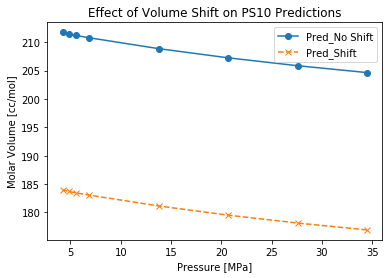

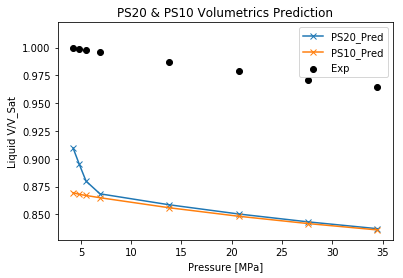

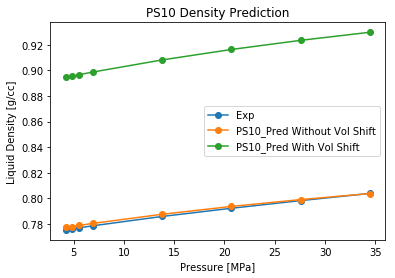

In [35]:

P_exp,den_exp,VV_exp,den_vec20,V_vec20,V_shift20,VV_vec20 = CompareExpePred(20);
P_exp,den_exp,VV_exp,den_vec10,V_vec10,V_shift10,VV_vec10 = CompareExpePred(10);

P_exp = [x*1e-6 for x in P_exp]
print('VV_shift10', VV_vec10)

# Figure #1: Show the effect of volume shifts on the case of PS10
plt.figure(1)
plt.plot(P_exp, V_vec10, label='Pred_No Shift', marker='o')
plt.plot(P_exp, V_shift10, label='Pred_Shift', marker='x', linestyle='dashed')
plt.title("Effect of Volume Shift on PS10 Predictions")
plt.xlabel('Pressure [MPa]')
plt.ylabel('Molar Volume [cc/mol]')
plt.legend(loc='upper right')

# Figure #2: Compare V/Vsat Plot of PS10 and PS20 against experimental data
plt.figure(2)
plt.scatter(P_exp, VV_exp, color='black', label='Exp', marker='o')
plt.plot(P_exp, VV_vec20, label='PS20_Pred', marker='x')
plt.plot(P_exp, VV_vec10, label='PS10_Pred', marker='x')
plt.title("PS20 & PS10 Volumetrics Prediction")
plt.xlabel('Pressure [MPa]')
plt.ylabel('Liquid V/V_Sat')
plt.legend(loc='upper right')

# Figure #3: Compare Density Plot of PS10 and PS20 against experimental data

print('shifted density', den_vec10)
den_shift = [0.9297882449334898, 0.9234647899274542, 0.9163198174865093, 0.9081486821637357, 0.8986602658039229, 0.8965697215907571, 0.8954970842402706, 0.8947538618022179]

plt.figure(3)
plt.plot(P_exp, den_exp, label='Exp', marker='o')
# plt.plot(P_exp, den_vec20, label='PS20_Pred', marker='o')
plt.plot(P_exp, den_vec10, label='PS10_Pred Without Vol Shift', marker='o')
plt.plot(P_exp, den_shift, label='PS10_Pred With Vol Shift', marker='o')
plt.title("PS10 Density Prediction")
plt.xlabel('Pressure [MPa]')
plt.ylabel('Liquid Density [g/cc]')
plt.legend(loc='center right')

# Effect of Changing MW and Kij - With Volume Shifts

In [26]:
def Tuning(Nps):
    
# Decide which pseudoization arrangement is desired
    if Nps == 20:
        Names,zi,MW,den,Tc,Pc,omega = Pseudo20()
    elif Nps == 10:
        Names,zi,MW,den,Tc,Pc,omega = Pseudo10()

    # -----------------------------  Input of the experimental results  ----------------------------------------------
    z_in = np.array([0.0032, 0.0004, 0.1565, 0.0413, 0.0402, 0.0101, 0.0285, 0.0153, 0.0176, \
                     0.0287, 0.0666, 0.0812, 0.0721, 0.4383]) # input mole fraction data
    MW_in = np.array([44.01, 28.01, 16.04, 30.07, 44.1, 58.12, 58.12, 72.15, 72.15, \
                      84, 96, 107, 121, 292]) # input molecular weight data (g/mole)
    den_in = np.array([0.8172, 0.8086, 0.2997, 0.3562, 0.507, 0.5629, 0.584, 0.6244, 0.6311, \
                       0.685, 0.722, 0.745, 0.764, 0.8959]) # input density data [g/cc]
    # Defined component critical temp input [K]
    Tc_in = np.array([304.2, 126.2, 190.6, 305.4, 369.8, 408.1, 425.2, 460.4, 469.6, 507.4])
    # Defined component critical pressure input [atm]
    Pc_in = np.array([72.9, 33.6, 45.4, 48.2, 41.9, 36.0, 37.5, 33.4, 33.3, 29.3])
    # Defined Component accentric factor input
    omega_in = np.array([0.228, 0.04, 0.008, 0.098, 0.152, 0.176, 0.193, 0.227, 0.251, 0.296]) 

    Pi = 1e6 # Initial pressure [Pa]
    T = 99 + 273.15 # in Kelvin
    R = 8.314 # gas constant
    EOS = 'PR'
    MW_tot = np.sum(zi[j]*MW[j] for j in range(Nps))

    # Create variables and vectors to initiate and store values
    P_vec = []
    den_vec = []
    V_vec = []
    V_shift = []
    VV_vec = []
    bi = []
    
    (P_exp, den_exp, VV_exp) = ([x*6894.76 for x in [5000, 4000, 3000, 2000, 1000, 800, 700, 612]],\
                            [0.8039, 0.7983, 0.7923, 0.7859, 0.7786, 0.777, 0.7761, 0.7754],\
                           [0.9645, 0.9713, 0.9786, 0.9867, 0.9959, 0.998, 0.999, 1]) 
                            # units: P [Pa], den [g/cc], V/Vsat [unitless]
    
    # Calculater hard-sphere b for each component to account for volume shift in the upcoming calculations
    for i in range(Nps):
        bi.append(calc_b(EOS, Tc[i], Pc[i])) # [m3/mol]
    
    ci = VolumeShift(Nps, bi)
    
    # Calculate Vsat using the bubble point routine: 
    P_bub = BPmain(T, Pi, Nps)

    l = 1; v = 0; Vv = 0
    xi = zi
    yi = np.zeros(len(zi))
    al = find_am(EOS,xi,T,Tc,Pc,omega)
    bl = find_bm(EOS,xi,Tc,Pc)
    Zl = MinGibbZ(EOS, P_bub, T, Tc, Pc, xi, omega, al, bl)
    Vl = np.divide(Zl*R*T, P_bub)*1e6 # [cc/mol]
    Vv = 0
    Vl_ssat = Vl - np.sum(np.multiply(xi[j], ci[j]) for j in range(Nps)) # [cc/mol]
    Vv_ssat = 0
    V_sat = (l*Vl_ssat+ v*Vv_ssat) # [cc/mol]
    

    for P in P_exp:

        l,xi,yi,Vv,Vl,Ki = main(T, P, Nps)

        if l>1:
            l = 1; v = 0; Vv = 0
            xi = zi
            yi = np.zeros(len(zi))
            al = find_am(EOS,xi,T,Tc,Pc,omega)
            bl = find_bm(EOS,xi,Tc,Pc)
            Zl = MinGibbZ(EOS, P, T, Tc, Pc, xi, omega, al, bl)
            Vl = np.divide(Zl*R*T, P)*1e6 # [cc/mol]
            Vv = 0
            V = (l*Vl+ v*Vv) ; V_vec.append(Vl)
            Vl_s = Vl - np.sum(np.multiply(xi[j], ci[j]) for j in range(Nps)) # [cc/mol]
            Vv_s = 0
            V_s= (l*Vl_s+ v*Vv_s); V_shift.append(Vl_s)# [cc/mol]
            VV_vec.append(Vl_s/V_sat)
            MW_tot = np.sum(zi[j]*MW[j] for j in range(Nps))
            den_vec.append(MW_tot/Vl_s)

        elif l<0:
            l = 0; v = 1; Vl = 0
            xi = np.zeros(len(zi))
            yi = zi
            av = find_am(EOS,yi,T,Tc,Pc,omega)
            bv = find_bm(EOS,yi,Tc,Pc)
            Zv = MinGibbZ(EOS, P, T, Tc, Pc, yi, omega, av, bv)
            Vl = 0
            Vv = np.divide(Zv*R*T, P)*1e6 # [cc/mol]
            V = (l*Vl+ v*Vv) ; V_vec.append(Vl) # [cc/mol]
            Vl_s = 0
            Vv_s = Vv - np.sum(np.multiply(yi[j], ci[j]) for j in range(Nps)) # [cc/mol]
            V_s= (l*Vl_s+ v*Vv_s); V_shift.append(Vl_s) # [cc/mol]
            VV_vec.append(Vl_s/V_sat)
            MW_tot = np.sum(yi[j]*MW[j] for j in range(Nps))
            den_vec.append(MW_tot/Vl_s)

        else:
            Vl = Vl*1e6
            Vv = Vv*1e6
            V = (l*Vl+ v*Vv) ; V_vec.append(Vl) # [cc/mol]
            Vl_s = Vl - np.sum(np.multiply(xi[j], ci[j]) for j in range(Nps)) # [cc/mol]
            Vv_s = Vv - np.sum(np.multiply(yi[j], ci[j]) for j in range(Nps)) # [cc/mol]
            V_s= (l*Vl_s+ v*Vv_s); V_shift.append(Vl_s) # [cc/mol]
            MW_tot = np.sum(xi[j]*MW[j] for j in range(Nps))
            VV_vec.append(Vl_s/V_sat)
            den_vec.append(MW_tot/Vl_s)
    print('VV_vec = ', VV_vec)
    return 

        # Figure: Compare Density Plot of PS10 before and after tuning
    plt.figure(1)
    plt.plot(P_exp, den_vec, label='density', marker='o')
    plt.title("Effect of Tuning")
    plt.xlabel('Pressure [Pa]')
    plt.ylabel('Density [g/cc]')
    plt.legend(loc='lower right')
    print('VV_vec = ', VV_vec)

    


In [27]:
Tuning(10)

iteration 2
Pressure =  1770637.954408375 l =  0.852737193049523 error =  1.2091480196948288
iteration 3
Pressure =  2356977.303844567 l =  0.889509556055253 error =  0.6914339279968051
iteration 4
Pressure =  3140063.8105109357 l =  0.9360306441632762 error =  0.30212927532625944
iteration 5
Pressure =  3747797.001352357 l =  0.9714829309738907 error =  0.1125601978720181
iteration 6
Pressure =  4108649.9903163165 l =  0.9925535360928145 error =  0.02671244625707203
iteration 7
Pressure =  4220933.25799744 l =  0.9991307454166425 error =  0.0030214205905396696
VV_vec =  [0.9620895808250849, 0.9686775203355896, 0.9762307501739943, 0.9850144589681522, 0.9954146376149344, 0.9977356599071822, 0.9989307598729588, 1.0005865605203]


Text(0.5,1,'Effect of Tuning Kij on PS 10 Saturation Pressure')

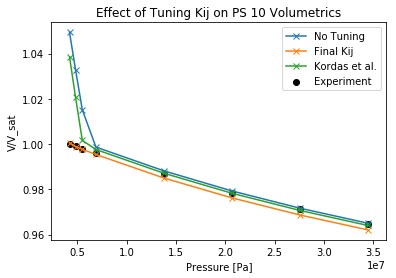

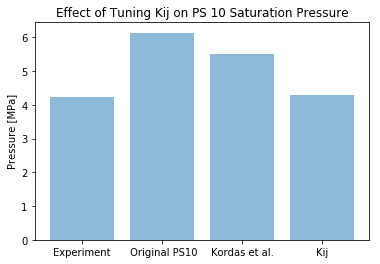

In [28]:
# With no tuning, we have
VV_vec =  [0.9650331491100634, 0.9716799834395341, 0.9793045327577679, 0.9881766086158349, 0.9986895746356336, 1.0151651364455883, 1.0329312457680253, 1.0494290151842347]
VV_exp =  [0.9645, 0.9713, 0.9786, 0.9867, 0.9959, 0.998, 0.999, 1]
P_exp =  [34473800.0, 27579040.0, 20684280.0, 13789520.0, 6894760.0, 5515808.0, 4826332.0, 4219593.12]

# Plot Results of Tuned Paramters
# For Kij: change as follows: (values are estimated based on notebook tables - as close as possible)
# kij[1, 7] = 0.1
# kij[1, 8] = 0.1
# kij[1, 9] = 0.1

# Results: 


VV_kor = [0.9640506466087173, 0.9706812799364085, 0.9782863227941074, 0.9871343807520054, 0.9976169028971846, 1.0016496897142246, 1.0208297433815812, 1.0386224797041494]

VV_veck =  [0.9620895808250849, 0.9686775203355896, 0.9762307501739943, 0.9850144589681522, 0.9954146376149344, 0.9977356599071822, 0.9989307598729588, 1.0005865605203]# For MW of heavy pseudocomponents: 
# MW[13] = 1.2*MW[13]
# MW[12] = 1.2*MW[12]

# Results:

VV_vecMW = [0.9636961536319331, 0.9704623551277817, 0.9782307152373279, 0.9872802429873321, 0.9980190864029714, 1.010235567094301, 1.027895115042659, 1.0442764012861623]
# Change both Kij and MW
# Changes are the same as above

# Results:

VV_veckMW =  [0.9613104848472047, 0.9680292966668043, 0.9757402331929884, 0.9847185425886951, 0.9953663519217338, 0.9977454009740502, 0.998970793550921, 1.0062928358756973]

plt.figure(1)
plt.plot(P_exp, VV_vec, label='No Tuning', marker='x')
plt.plot(P_exp, VV_veck, label='Final Kij', marker='x')
plt.plot(P_exp, VV_kor, label='Kordas et al.', marker='x')
plt.scatter(P_exp, VV_exp, label='Experiment', color='black', marker='o')
# plt.plot(P_exp, VV_veckMW, label='Kij&MW Tuning', marker='o')
plt.title("Effect of Tuning Kij on PS 10 Volumetrics")
plt.xlabel('Pressure [Pa]')
plt.ylabel('V/V_sat')
plt.legend(loc='upper right')

#x = ['Experiment', ' Original PS10', 'Kij', 'MW', 'Kij&MW']
#y = [4.22,6.133561, 7.901413, 6.550592, 8.465109]

x = ['Experiment', ' Original PS10', 'Kordas et al.','Kij']
y = [4.22,6.133561,5.491128, 4.284744]

plt.figure(2)
plt.bar(x, y, align='center', alpha=0.5)
plt.ylabel('Pressure [MPa]')
plt.title('Effect of Tuning Kij on PS 10 Saturation Pressure')

# PT Diagram Using Bubble Point Routine

In [29]:
x = np.array([1,2,3,4,5])
y = np.array([10, 20, 20, 30])

z = np.concatenate((x,y))
z
t = z[::-1]
t

array([30, 20, 20, 10,  5,  4,  3,  2,  1])

iteration 2
Pressure =  1470429.9572490468 l =  0.9554329277494955 error =  0.2461158719363421
iteration 3
Pressure =  1687183.2592456508 l =  0.9793793971928764 error =  0.09891778056568601
iteration 4
Pressure =  1832842.4547157774 l =  0.9955413738850412 error =  0.019620061883621087
bubble 1
iteration 2
Pressure =  2198841.341272655 l =  0.9453247573289549 error =  0.28724049964087084
iteration 3
Pressure =  2560352.438062843 l =  0.9720860632771698 error =  0.12189684839440695
iteration 4
Pressure =  2826870.4629529687 l =  0.9933254268018602 error =  0.0271384293360335
iteration 5
Pressure =  2903200.15119739 l =  0.9991825402568015 error =  0.003232477947552992
bubble 2
iteration 2
Pressure =  3381574.0015760427 l =  0.9487983919686288 error =  0.22524564477877873
iteration 3
Pressure =  3861743.9398286236 l =  0.9766804537606467 error =  0.08956915712359614
iteration 4
Pressure =  4178736.3486730903 l =  0.9951323252049729 error =  0.017214624844522408
bubble 3
iteration 2
Pres

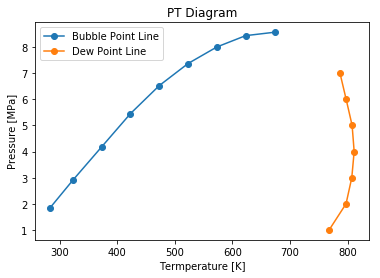

In [30]:
Nps = 10
Pbi = 1e6
kb = 0
P_bub = BPmain(10 + 273.15, Pbi, Nps)
P_vecb = [P_bub]

T_vecb = 273.15 + np.arange(50, 450, 50) # [K]

for T in T_vecb: 
    print('bubble', kb+1)
    P_vecb.append(BPmain(T, 0.8*P_vecb[kb], Nps))
    kb +=1
    

kd = 0
Tdi = 600
T_dew = DPmainT(Tdi, 1e6, Nps)
T_vecd = [T_dew]

P_vecd = np.arange(2e6, 8e6, 1e6) # [Pa]

for P in P_vecd:
    print('Dew', kd+1)
    T_vecd.append(DPmainT(0.8*T_vecd[kd], P, Nps))
    kd +=1


T_vecb = np.insert(T_vecb, 0, 10 + 273.15)
P_vecd = np.insert(P_vecd, 0, 1e6)

# g = P_vecb[-1:]
# h = T_vecb[-1:]

# g = np.concatenate((P_vecd[-2:],g[::-1]))
# h = np.concatenate((T_vecd[-2:],h[::-1]))

# # calculate polynomial
# z = np.polyfit(h, g, 3)
# f = np.poly1d(z)

# # calculate new x's and y's
# CP_T = np.linspace(h[0], h[-1], 50)
# CP_P = f(CP_T)

# CP_T = np.concatenate((T_vecd, T_vecb[::-1]))
# CP_P = np.concatenate((P_vecd, P_vecb[::-1]))

P_vecb = [x * 1e-6 for x in P_vecb]
P_vecd = [x * 1e-6 for x in P_vecd]

print(T_vecd)
print(P_vecd)
plt.plot(T_vecb, P_vecb, marker='o', label='Bubble Point Line')
plt.plot(T_vecd, P_vecd, marker='o', label='Dew Point Line')
plt.title("PT Diagram")
plt.ylabel('Pressure [MPa]')
plt.xlabel('Termperature [K]')
plt.legend()
plt.show()
       

# Flash Algorithm Modified to Accommodate for Mole Fraction Input and to Output the corrected volumes

In [31]:
def mainmol(T, P, Nps, yi):
    # The inputs of the problem:
    R = 8.314 # gas constant
    
    # Decide which pseudoization arrangement is desired
    if Nps == 20:
        Names,zi,MW,den,Tc,Pc,omega = Pseudo20()
    elif Nps == 10:
        Names,zi,MW,den,Tc,Pc,omega = Pseudo10()
    
    zi = yi
    # Note the units: zi [fraction], MW[g/mole], den [g/cc], Tc[K], Pc[Pa], omega [unitless]

    Nc = zi.size # number of components
    Ki = np.multiply(Pc/P, np.exp(5.37*np.multiply((1+omega), (1-Tc/T)))) # inital K-values Using Wilson EQ
    Ki[np.isnan(Ki)] = 0.1
    EOS = 'PR' # Equation of State we are interested to use
    tol  = 1e-5
    conv = 0
    
    # using Rachford Rice equation to obtain l (Flash)
    # initial guess
    l_initial = 0.5
    criteria = np.ones(Nc) # random assignment to enter the loop
    record = []
    iterate = 0
    
    # Construct Rachford-Rice function F(L) to plot 
    L = sp.Symbol('L')
    F = np.sum(np.divide(np.multiply(zi, (1-Ki)),(Ki+(1-Ki)*L)))
    
    while all(x > tol for x in criteria):
        
        # Plot Rachford-Rice: 
        #sp.plot(F, xlim=[-1, 5], ylim=[-2,2])
        
        l = RachfordNewtonBisection(l_initial, Nc, zi, Ki)
        #print('Rachford-Rice L = ', l)
        
        # calculating liquid and gas compositions (Eq. 6.15 and 6.16, respectively)
        xi = np.divide(zi, l+(1-l)*Ki)
        yi = np.divide(np.multiply(Ki, zi), (l+(1-l)*Ki))
        
        # calculating the a's and b's of the vapor and liquid phases
        av = find_am(EOS,yi,T,Tc,Pc,omega)
        al = find_am(EOS,xi,T,Tc,Pc,omega)

        bv = find_bm(EOS,yi,Tc,Pc)
        bl = find_bm(EOS,xi,Tc,Pc)

        # calculating the vapor and liquid Z-factors
        
        #Method 1: Max/Min Approach:
#         Zv = max(Z_factor(EOS,P,T,av,bv))
#         Zl = min(Z_factor(EOS,P,T,al,bl))
        
        #Method 2: Min Free Gibb's Energy Approach:
        Zv = MinGibbZ(EOS, P, T, Tc, Pc, yi, omega, av, bv)
        Zl = MinGibbZ(EOS, P, T, Tc, Pc, xi, omega, al, bl)
        
        # calculating the vapor and liquid volumes from PV = ZRT
        Vv = np.divide(Zv*R*T, P)
        Vl = np.divide(Zl*R*T, P)

        # Fugacity values of vapor and liquid
        fug_v = get_fug(EOS, yi, Zv, Tc, Pc, P, T, omega, av, bv)
        fug_l = get_fug(EOS, xi, Zl, Tc, Pc, P, T, omega, al, bl)
        
        # Calculate for convergence 
        criteria = np.absolute(np.divide(fug_l,fug_v) -1)
        
        # Update Ki values and let the loop check if fugacities are equal
        Ki = np.multiply(np.divide(fug_l,fug_v), Ki)
        Ki[np.isnan(Ki)] = 0.1
        iterate += 1
        
    if l>1:
        l = 1; v = 0; Vv = 0
        xi = zi
        yi = np.zeros(len(zi))
        al = find_am(EOS,xi,T,Tc,Pc,omega)
        bl = find_bm(EOS,xi,Tc,Pc)
        Zl = MinGibbZ(EOS, P, T, Tc, Pc, xi, omega, al, bl)
        Vl = np.divide(Zl*R*T, P) # [m3/mol]

    elif l<0:
        l = 0; v = 1; Vl = 0
        xi = np.zeros(len(zi))
        yi = zi
        av = find_am(EOS,yi,T,Tc,Pc,omega)
        bv = find_bm(EOS,yi,Tc,Pc)
        Zv = MinGibbZ(EOS, P, T, Tc, Pc, yi, omega, av, bv)
        Vv = np.divide(Zv*R*T, P)*1e6 # [m3/mol]
    else: 
        v = 1-l
    return l, v, xi, yi, Vv, Vl, Ki
#     v = 1-l
#     V = l*Vl+ v*Vv
    
#     if l>1:
#         l = 1; v = 0
#         V = l*Vl+ v*Vv
#         xi = zi
#         yi = np.zeros(len(zi))
    

#     elif l<0:
#         l = 0; v = 1
#         V = l*Vl+ v*Vv
#         xi = np.zeros(len(zi))
#         yi = zi
    
#     print('V = ', V)
#     ndprint(xi, 'xi = ', format_string ='{0:.3f}')
#     ndprint(yi, 'yi = ', format_string ='{0:.3f}')
#     print('Vl = {:.5e}'.format(Vl))
#     print('Vv = {:.5e}'.format(Vv))
#     print('l = {:.3f}'.format(l))
#     print('v = {:.3f}'.format(v))
#     print('Iterateions = ', iterate)

# Differential Liberation Routine

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in multiply
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log


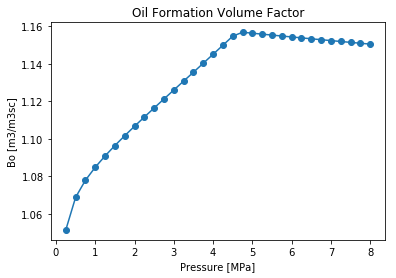

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


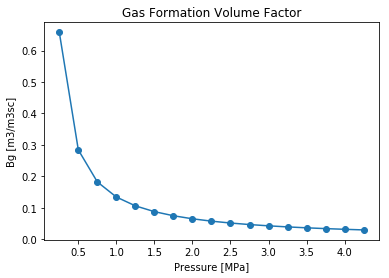

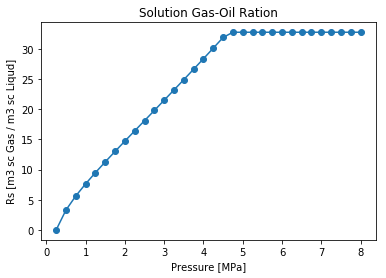

In [32]:
def DiffLib(Nps):
    
    # Decide which pseudoization arrangement is desired
    if Nps == 20:
        Names,zi,MW,den,Tc,Pc,omega = Pseudo20()
    elif Nps == 10:
        Names,zi,MW,den,Tc,Pc,omega = Pseudo10()
        
    # The inputs of the problem:
    T = 99 + 273+15 # [Kelvin] Temperature
    Psat = 4.23e6 # [Pa] Saturation Pressure based on CME
    nt = 1 # [mole] Total number of moles before the start of the experiment
    R = 8.314 # gas constant
    Psc = 101325 # Pa
    Tsc = 16.6 + 273.15 # Kelvin
    
    ntv_vec = []
    ntl_vec = []
    Vtv_vec = []
    Vtl_vec = []
    Vvsc_vec = []
    Vtvsc_vec = []
    Rs = []
    l_vec = []
    
    P_vec = np.arange(0.8e7, 1e5, -2.5e5)
    #P_vec =  np.concatenate([P_vec, np.arange(5e5, 1e5, -2e5), [Psc]])
    
    for k in range(len(P_vec)):
        
        l,v,xi,yi,Vv,Vl,Ki = mainmol(T, P_vec[k], Nps, zi)
        
        l_vec.append(l)
        ntv_vec.append(v*nt)
        ntl_vec.append(l*nt)
        Vtv_vec.append(ntv_vec[k]*Vv)
        Vtl_vec.append(ntl_vec[k]*Vl)
        
        l,v,gi,hi,Vv,Vl,Ki = mainmol(Tsc, Psc, Nps, yi)
        Vvsc_vec.append(Vv)
        Vtvsc_vec.append(v*ntv_vec[k]*Vvsc_vec[k])

        nt = ntl_vec[k]
        zi = xi
        
    l,v,xi,yi,Vv,Vl,Ki = mainmol(Tsc, Psc, Nps, xi)
    Vtlsc = l*nt*Vl
    
    
    P_vec = [x * 1e-6 for x in P_vec]
    # Caluculate and plot oil formation volume factor [bb]
    Bo = Vtl_vec/Vtlsc
    plt.figure(1)
    plt.plot(P_vec, Bo, marker='o')
    plt.title("Oil Formation Volume Factor")
    plt.ylabel('Bo [m3/m3sc]')
    plt.xlabel('Pressure [MPa]')
    plt.show()

    Bg = np.divide(Vtv_vec,Vtvsc_vec)
    Bg[np.isnan(Bg)] = 0
    plt.figure(2)
    plt.plot(P_vec[15:], Bg[15:], marker='o')
    plt.title("Gas Formation Volume Factor")
    plt.ylabel('Bg [m3/m3sc]')
    plt.xlabel('Pressure [MPa]')
    plt.show()

    for j in range(len(P_vec)):
        Rs.append(np.sum(Vtvsc_vec[i] for i in range(j+1, len(P_vec))) / Vtlsc)
    plt.figure(3)
    plt.plot(P_vec, Rs, marker='o')
    plt.title("Solution Gas-Oil Ration")
    plt.ylabel('Rs [m3 sc Gas / m3 sc Liqud]')
    plt.xlabel('Pressure [MPa]')
    plt.show()

DiffLib(10)

# Methance Reference Viscosity Estimation - Credit to Prof Kovscek

In [33]:
# Computes reference viscosity of methane using the correlation of Hanley et al. Cyrogenics, July 1975
# To be used for corresponding states computation of mixture viscosity
# A. R. Kovscek
# 20 November 2018

    
# Tref is the reference temperature in K (viscosity computed at this temperature)
# rho_ref is the reference density in g/cm3 (viscosity computed at this temperature and density)
# mu_C1 is the viscosity from correlation in mPa-s (identical to cP)
def ViscMethane(Tref,rho_ref):
    import math
    #Local variables
    #critical density of methane (g/cm^3)
    rho_c=16.043/99.2
    #parameters for the dilute gas coefficient
    GV=[-209097.5,264726.9,-147281.8,47167.40,-9491.872,1219.979,-96.27993,4.274152,-0.08141531]
    #parameters for the first density correction term
    Avisc1 = 1.696985927
    Bvisc1 = -0.133372346
    Cvisc1 = 1.4
    Fvisc1 = 168.0
    #parameters for the viscosity remainder
    j1 = -10.35060586
    j2 = 17.571599671
    j3 = -3019.3918656
    j4 = 188.73011594
    j5 = 0.042903609488
    j6 = 145.29023444
    j7 = 6127.6818706
    #compute dilute gas coefficient
    visc0 = 0.
    exp1 = 0.
    for i in range(0,len(GV)):
        exp1 = -1. + (i)*1./3.
        visc0 = visc0 + GV[i]*math.pow(Tref,exp1)
    #first density coefficient
    visc1 = Avisc1+Bvisc1*math.pow((Cvisc1-math.log(Tref/Fvisc1)),2.)
    #viscosity remainder
    theta=(rho_ref-rho_c)/rho_c
    visc2 = math.pow(rho_ref,0.1)
    visc2 = visc2*(j2+j3/math.pow(Tref,1.5))+theta*math.sqrt(rho_ref)*(j5+j6/Tref+j7/math.pow(Tref,2.))
    visc2 = math.exp(visc2)
    visc2 = visc2 - 1.
    visc2 = math.exp(j1+j4/Tref)*visc2
    #methane viscosity at T and density (Tref,rho_ref)
    #multiply by 10-4 to convert to mPa-s(cP)
    mu_C1 = (visc0+visc1+visc2)*0.0001
       
    return (mu_C1)

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
c 6.755498140417104e-07
b 2.6773104278260868e-05
Pcmix 2030368.8336528586
Tcmix 710.76913512127
MWmix 253.36342835689942
alphamix 2.02576237013915
alphao 1.2460441663832031
Vo 29.332948738112343
rhoo with alpha 0.5469276254233283
To 61.31988668310283
Po 480780.5889497977
methane viscosity 3.5261683852978147
mixture viscosity 10.603642669474759


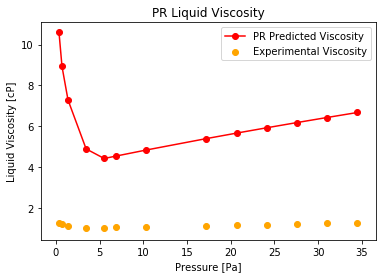

In [34]:
P_vec = np.array([3.45e7, 3.10e7, 2.76e7, 2.41e7, 2.07e7, 1.72e7, 1.03e7, 6.89e6, 5.52e6, 3.45e6, 1.38e6, 6.89e5, 3.45e5])
#P_vec = np.arange(3.45e7, 0, -1e7)
vismix_exp = [1.27, 1.24, 1.21, 1.18, 1.14, 1.11, 1.08, 1.05, 1.01, 1.02, 1.13, 1.20, 1.26]
vismix_vec = []
k = 1

for P in P_vec:
    print('iteration', k)
    k +=1

    #Function Input
    Nps = 10

    # Methane Properties: 
    Pco = 46e5 # Pa
    Tco = 190.40 # Kelvin
    Vco = 99.2 # cc/mol
    omegao = 0.011
    MWo = 16.043 # g/mol
    rhoco = 161.7e-3 #g/cc

    # Decide which pseudoization arrangement is desired
    if Nps == 20:
        Names,zi,MW,den,Tc,Pc,omega = Pseudo20()
    elif Nps == 10:
        Names,zi,MW,den,Tc,Pc,omega = Pseudo10()

    T = 99 + 273.15 # [Kelvin] Temperature
    R = 8.314 # gas constant
    EOS = 'PR'

    # Compute liquid mixture critical temperature, critical pressure, and molecular weight
    l,v,xi,yi,Vv,Vl,Ki = mainmol(T, P, Nps, zi)

    num = np.sum(np.sum((xi[i]*xi[j]*np.sqrt(Tc[i]*Tc[j])*((Tc[i]/Pc[i])**(1/3) + (Tc[j]/Pc[j])**(1/3))**3)\
                      for i in range(len(zi))) for j in range(len(zi)))
    den = np.sum(np.sum((xi[i]*xi[j]*((Tc[i]/Pc[i])**(1/3) + (Tc[j]/Pc[j])**(1/3))**3) for i in range(len(zi)))\
                       for j in range(len(zi)))
    Tcmix = num/den
    Pcmix = 8*num/den**2

    MW_w = np.sum(xi[i]*MW[i]**2 for i in range(len(zi)))/np.sum(xi[i]*MW[i] for i in range(len(zi)))
    MW_n = np.sum(xi[i]*MW[i] for i in range(len(zi)))
    MWmix = 1.304e-4*(MW_w**2.303 - MW_n**2.303) + MW_n

    # Compute the reduced temperature and pressure without coupling coefficients 
    To = T*Tco/Tcmix
    Po = P*Pco/Pcmix
    #So = -0.1540
    ZRa = 0.29056 - 0.08775*omegao
    c = 0.40768*(0.29441 - ZRa)*R*Tco/Pco
    
    # Find the methane volume and invert for density using PR EOS and compute the reduced density
    a = calc_a(EOS, To, Tco, Pco, omegao)
    b = calc_b(EOS, Tco, Pco)
    Zo = MinGibbZ (EOS, Po, To, [Tco], [Pco], [1], [omegao], a, b)
    Vo = np.divide(Zo*R*To, Po)*1e6 # cc/mol
    #Vo = Vo - So*b
    Vo = Vo - c
    rhoo = MWo/Vo # g/cc 
    rhor = rhoo/rhoco
    
    # Solve for the coupling coefficient
    alphamix = 1 + 7.378e-3 * rhor**1.847 * MWmix**0.5173
    alphao = 1 + 0.031 * rhor**1.847

    # Find To and Po using alpha
    To = (T*Tco/Tcmix)*(alphao/alphamix)
    Po = (P*Pco/Pcmix)*(alphao/alphamix)
    
    # Find methane density at new reference temperature and pressure 
    a = calc_a(EOS, To, Tco, Pco, omegao)
    b = calc_b(EOS, Tco, Pco)
    Zo = MinGibbZ (EOS, Po, To, [Tco], [Pco], [1], [omegao], a, b)
    Vo = np.divide(Zo*R*To, Po)*1e6 # cc/mol
    #Vo = Vo - So*b
    Vo = Vo - c
    rhoo = MWo/Vo # g/cc
 
    # Find methance viscosity using Prof Kovscek's Routine
    viso = ViscMethane(To,rhoo)

    # Calculate mixture viscosity: 
    vismix = (Tcmix/Tco)**(-1/6) * (Pcmix/Pco)**(2/3) * (MWmix/MWo)**(1/2) * (alphamix/alphao) * viso
    vismix_vec.append(vismix)

print('c', c)
print('b', b)
print('Pcmix', Pcmix)
print('Tcmix', Tcmix)
print('MWmix', MWmix)
print('alphamix', alphamix)
print('alphao', alphao)
print('Vo', Vo)
print('rhoo with alpha', rhoo)
print('To', To)
print('Po', Po)
print('methane viscosity', viso)
print('mixture viscosity', vismix)

P_vec = [x *1e-6 for x in P_vec]
plt.plot(P_vec, vismix_vec, color = 'red', marker='o', label='PR Predicted Viscosity')
plt.scatter(P_vec, vismix_exp, color='orange', marker='o', label='Experimental Viscosity')
plt.title("PR Liquid Viscosity")
plt.ylabel('Liquid Viscosity [cP]')
plt.xlabel('Pressure [Pa]')
plt.legend()
plt.show()